<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL
import os.path
from os.path import join

In [17]:
"""This notebook is designed to run on Google Colab.
If it detects that it is running on Colab, it downloads the rest of its repository from Github
and mounts a Google Drive to save the checkpoint files. The idea is that you can just run it
by itself, and it pulls in everything else it needs.
"""

USERNAME = "colaprograms"
REPOSITORY = "torch-template"
GOOGLE_DRIVE_CHECKPOINT_DIR = "code/checkpoint"

if exists("/content"):
    print("We're on Google Colab!")
    CODE_PATH = join("/content", REPOSITORY)
    if not os.path.exists(CODE_PATH):
        print(f"Cloning new copy of the repository {REPOSITORY} into {CODE_PATH}")
        !git clone https://github.com/${USERNAME}/{REPOSITORY}
    os.chdir(CODE_PATH)
    "The code may have changed on GitHub since we cloned it"
    !git pull
    
    # Download data files here
    
    "Mount Google Drive on /content/gdrive/My Drive and try to save checkpoints in CHECKPOINT_DIR_ON_COLAB"
    print("Now mounting your Google Drive (not mine, yours)")
    from google.colab import drive
    drive.mount("/content/gdrive")
    CHECKPOINT_PATH = join("/content/gdrive/My Drive", GOOGLE_DRIVE_CHECKPOINT_DIR)
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)
else:
    print("We're in a Jupyter notebook!")
    if os.path.exists("../notebooks"):
        "Move out of the notebooks directory"
        os.chdir("..")
    CODE_PATH = os.getcwd()
    CHECKPOINT_PATH = join(CODE_PATH, "checkpoint")
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)

print("Changing directory to", CODE_PATH)
os.chdir(CODE_PATH)
print("Checkpoints are going to", CHECKPOINT_PATH)

We're in a Jupyter notebook!
Changing directory to /home/gibson/sdb2/cola/ass/balls/template
Checkpoints are going to /home/gibson/sdb2/cola/ass/balls/template/checkpoint


In [18]:
import torch.nn as nn
import torch.optim as optim
import torchvision

# Numpy will show all numbers to 4 decimal places
np.set_printoptions(4, suppress=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reloading util.file
Using images in ../AI4Good---Meza-OCR-Challenge

Reloading util.chars

Reloading nets.ctcnet

Loaded 6747 training images and 750 validation images
Showing an example training image

Label: 13.4
Image mean: [0. 0. 0.]
Image std dev: [0.5 0.5 0.5]


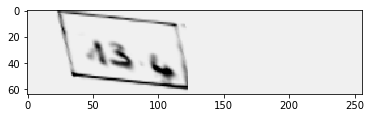

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Showing an example validation image

Label: 168
Image mean: [0. 0. 0.]
Image std dev: [0.5 0.5 0.5]


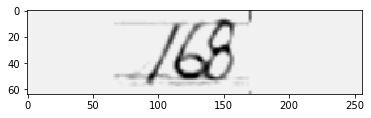

In [19]:
# Reload all of our modules in case they changed

modules_to_reload = [
    "util.file",
    "util.chars",
    "nets.ctcnet"
]

from importlib import import_module, reload
for module in modules_to_reload:
    print("Reloading %s" % module)
    reload(import_module(module))
    print()

from util.chars import chars, nchars, idx, input_to_string
from util.file import FileHolder
from nets.ctcnet import CTCModel

fh = FileHolder()
print("Loaded %d training images and %d validation images" %
     (fh.ntraining(), fh.nvalidation()))

def show(z):
    print()
    b = z[0].numpy().squeeze().transpose(1, 2, 0)
    print("Label:", z[1][0])
    print("Image mean:", np.mean(b, axis=(0, 1)))
    print("Image std dev:", np.std(b, axis=(0, 1)))
    p.imshow(b * 0.3 + 0.9)
    p.show()

print("Showing an example training image")
b = fh.get_batch_tensor(1)
show(b)

print()
print("Showing an example validation image")
b = fh.get_batch_tensor(1, validation=True)
show(b)

In [20]:
BATCH_SIZE = 64

class Runner:
    def __init__(self):
        self.model = CTCModel().cuda()
        self.loss = nn.CTCLoss(reduction='sum').cuda()
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr = 0.0001, # It gets pretty unstable with larger lrs.
            momentum = 0.9,
            nesterov = True, # Everyone loves Nesterov
            weight_decay = 0.001 # A little bit of regularization
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            patience=6,
            verbose=True
        )
        self.trainloss = []
        self.validloss = []
        
    def predict(self, inputs):
        # Enter evaluation mode
        self.model.eval()
        return self.model(inputs.clone().cuda())
    
    def one_batch_loss(self, inputs, outputs):
        inputs = self.model(inputs.clone().cuda())
        inputs = inputs.permute(1, 0, 2)
        # sequence, batch, channels
        # All sequences should be 32 long, because that's
        # the size of the image after we pad to 256 pixels
        # and then run it through the convolutions.
        assert inputs.shape[0] == 32
        input_lengths = torch.tensor(
            [32 for i in range(inputs.shape[1])],
            dtype=torch.int32
        )
        target, target_lengths = Runner.maketarget(outputs)
        
        loss = self.loss(inputs, target, input_lengths, target_lengths)
        return loss
    
    @staticmethod
    def maketarget(outputs):
        classes = []
        "Concatenate all the outputs into one array"
        for string in outputs:
            classes.extend([idx[c] for c in string])
        lengths = [len(string) for string in outputs]
        # We use int32 because Torch promises us that we
        # can use special CuDNN code if we meet some
        # requirements, and one of the requirements is
        # that these tensors have type torch.int32.
        return (
            torch.tensor(classes, dtype=torch.int32),
            torch.tensor(lengths, dtype=torch.int32)
        )

    @staticmethod
    def logits_to_string(logits):
        assert logits.shape[0] == 1
        length = logits.shape[1]
        if isinstance(logits, torch.Tensor):
            logits = logits.clone().detach().cpu().numpy()
        def randchoice(p):
            p = np.exp(p)
            if np.abs(np.sum(p) - 1) > 1e-6:
                raise Exception("logits are not properly normalized")
            u = random.random()
            for i in range(p.shape[0]):
                u -= p[i]
                if u < 1e-6:
                    return i
        def characterat(j):
            return chars[randchoice(logits[0, j, :])]
        return "".join(characterat(j) for j in range(length))
    
    def __train(self, epoch):
        # set training mode just in case it has somehow been unset
        self.model.train()
        running_loss = 0.0
        length = 0
        #print("Example output:")
        import time
        if epoch == 0:
          start = time.time()
        for i in range(100):
          inputs, outputs = fh.get_batch_tensor(BATCH_SIZE)
          self.optimizer.zero_grad()
          loss = self.one_batch_loss(inputs, outputs)
          loss.backward()
          self.optimizer.step()
          running_loss += loss.item()
          length += BATCH_SIZE
          if epoch == 0 and i == 10:
            elapsed = time.time() - start
            print("Each epoch should take about %.1f minutes." % (elapsed*10/60))
            print("The best time for this model seems to be around 50 epochs.")
            loss = None
        trainingloss = running_loss / length
        print("Epoch %d. Loss: %f" % (epoch, trainingloss))
        self.trainloss.append(trainingloss)
    
    def __valid(self, epoch):
        running_loss = 0.0
        length = 0
        with torch.no_grad():
            for i in range(100):
                inputs, outputs = fh.get_batch_tensor(BATCH_SIZE, validation=True)
                loss = self.one_batch_loss(inputs, outputs)
                running_loss += loss.item()
                length += BATCH_SIZE
        validationloss = running_loss / length
        self.scheduler.step(validationloss)
        print("Validation loss: %f" % validationloss)
        self.validloss.append(validationloss)
        file = join(CHECKPOINT_PATH, "checkpoint-%04d-%.2f" % (epoch, validationloss))
        torch.save({
            'model': self.model.state_dict(),
            'trainloss': self.trainloss,
            'validloss': self.validloss
        }, file)
        print("Saved", file)
    
    def load_from(self, file):
        checkpoint = torch.load(file)
        self.model.load_state_dict(checkpoint['model'])
        self.trainloss, self.validloss = checkpoint['trainloss'], checkpoint['validloss']
        
    def run(self, epochs, resume_checkpoint=None):
        if resume_checkpoint is None:
            print("Training network from scratch")
        else:
            self.load_from(resume_checkpoint)
        for epoch in range(epochs):
            self.__train(epoch)
            self.__valid(epoch)

blade = Runner()
blade.run(100, resume_checkpoint=None)

RuntimeError: CUDA error: out of memory